In [1]:
from numerapi import NumerAPI, utils
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# initialize API client
napi = NumerAPI()

In [2]:
query_models = '''query simpleRoundsRequest($my_round: Int!) {
  RoundDetails(roundNumber: $my_round, tournament:8) {
    roundNumber,
    totalAtStake,
    totalPayout,
    totalStakes,
    status,
    payoutFactor,
    openTime,
    models {
      modelName,
      selectedStakeValue
    }    
  }
}'''

args = {'my_round':331}
data = napi.raw_query(query_models, args)['data']['RoundDetails']
staked_models = pd.DataFrame(data['models'])
staked_models.selectedStakeValue = staked_models.selectedStakeValue.astype(float)

In [4]:
query = '''query simpleRoundsRequest($my_model: String!) {
  v3UserProfile(modelName: $my_model) {

    username,
    roundModelPerformances {
      roundNumber,
      corr,
      mmc,
      fncV3,
      tc,
      corrWMetamodel
    }    
  }
}'''

result = pd.DataFrame()
for m in staked_models.sort_values(by='modelName').modelName:
    #print(m)

    args = {'my_model': m}
    data = napi.raw_query(query, args)['data']
    userData = pd.DataFrame(data['v3UserProfile']['roundModelPerformances']).dropna()
    userData['model']=m
    userData = userData[(userData.roundNumber<331)]
    
    result = pd.concat([result, userData])
    
print('Finished')

Finished


In [5]:
result_backup = result.copy()

In [136]:
result = result_backup.copy()

result = result[result.model.isin(staked_models.loc[staked_models.selectedStakeValue>10, 'modelName'])]
result = result[result.roundNumber>250].dropna()
result.tc = result.tc.astype(np.float32)
result

,corr,corrWMetamodel,fncV3,mmc,roundNumber,tc,model
5,0.044591,0.797568,0.019610,0.012900,330,0.007807,001l_xr_l_t0_f0_n0_0
6,0.047693,0.798076,0.016964,0.001459,329,0.041591,001l_xr_l_t0_f0_n0_0
7,0.031835,0.822718,0.014376,0.000259,328,0.009254,001l_xr_l_t0_f0_n0_0
8,0.042042,0.814899,0.021943,0.012329,327,0.033881,001l_xr_l_t0_f0_n0_0
9,0.030762,0.819834,0.025993,0.007210,326,-0.047012,001l_xr_l_t0_f0_n0_0
...,...,...,...,...,...,...,...
64,-0.005633,0.790691,0.012823,-0.003186,271,-0.036672,zuikaku
65,-0.009972,0.782386,-0.007329,-0.001181,270,-0.071285,zuikaku
66,0.026541,0.786255,0.013431,0.004149,269,-0.015239,zuikaku
67,0.058281,0.783191,0.017482,0.007770,268,0.024424,zuikaku


In [137]:
agg = result.groupby('model').agg('mean')
agg[['corr','corrWMetamodel','fncV3','mmc','tc']].corr()

,corr,corrWMetamodel,fncV3,mmc,tc
corr,1.000000,0.578344,0.599415,0.628154,0.231444
corrWMetamodel,0.578344,1.000000,0.317237,-0.138091,-0.109184
fncV3,0.599415,0.317237,1.000000,0.304712,0.451433
mmc,0.628154,-0.138091,0.304712,1.000000,0.280884
tc,0.231444,-0.109184,0.451433,0.280884,1.000000


# Metamodel correlation - True Contribution

In [138]:
bins = np.percentile(agg.corrWMetamodel, [i for i in range(10,100,10)])
bins = [-1] + list(bins) + [1]
agg['metaCorr_quantile'] = pd.cut(agg.corrWMetamodel, bins, labels = [i+1 for i in range(0, 10)])


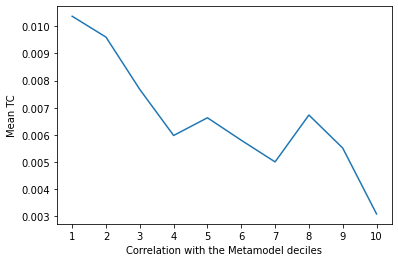

In [142]:
a = agg.groupby(agg.metaCorr_quantile).agg('mean')
plt.plot(a.index, a.tc)
plt.xlabel('Correlation with the Metamodel deciles')
plt.ylabel('Mean TC')
plt.xticks([i for i in range(1, 11)])
plt.show()

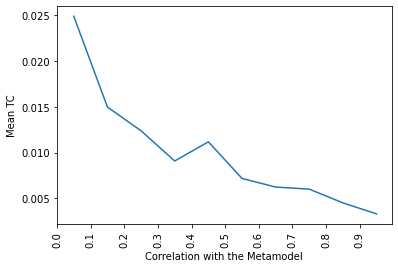

In [143]:
start = -0
chart = []
for r in np.arange(start, 1, 0.1):
    chart.append((r+0.05, agg.loc[(agg.corrWMetamodel>r) & (agg.corrWMetamodel<r+0.1), 'tc'].mean(), agg.loc[(agg.corrWMetamodel>r) & (agg.corrWMetamodel<r+0.1), 'tc'].count()))

chart = pd.DataFrame(chart, columns=['metaCorr', 'tc', 'count'])
plt.plot(chart.metaCorr, chart.tc)
plt.xticks(np.arange(start, 1, 0.1), rotation=90)

plt.xlabel('Correlation with the Metamodel')
plt.ylabel('Mean TC')
plt.show()